In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow
from tensorflow import keras
# from tensorflowkeras.utils.vis_utils import plot_model
import random
from sklearn.model_selection import train_test_split
from scipy import ndimage
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

In [16]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [17]:
x_train = x_train / 255.
x_test = x_test / 255.

In [19]:
unlabeld_index = np.ones(y_train.shape, bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

In [20]:
x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

In [21]:
print(x_unlabeld.shape)
print(x_train.shape)
print(y_train.shape)

(49800, 32, 32, 3)
(200, 32, 32, 3)
(200, 1)


In [22]:
angle_classifier_no = 4
cifar10_classifier_no = 10

In [23]:
y_train = keras.utils.to_categorical(y_train, cifar10_classifier_no)
y_test = keras.utils.to_categorical(y_test, cifar10_classifier_no)

In [24]:
pseudo_label = []
rotate_const = [
    cv2.ROTATE_90_CLOCKWISE,
    cv2.ROTATE_180,
    cv2.ROTATE_90_COUNTERCLOCKWISE,
    3
]

for i, img in enumerate(x_unlabeld):
    output = random.choice(rotate_const)
    if output == 3:
        pseudo_label.append([output])
        continue
    x_unlabeld[i] = cv2.rotate(img[:], output)
    pseudo_label.append([output])

pseudo_label = np.array(pseudo_label)

In [25]:
pseudo_label = keras.utils.to_categorical(pseudo_label, angle_classifier_no)


In [26]:
x = np.concatenate((x_unlabeld, x_train))
y_angle = np.concatenate(
    (
        pseudo_label, 
        np.full((x_train.shape[0], angle_classifier_no), [0, 0, 0, 1])
    )
)
y_cifar10 = np.concatenate(
    (
        np.full((x_unlabeld.shape[0], cifar10_classifier_no), [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        y_train
    )
)

In [27]:
x.shape, y_angle.shape, y_cifar10.shape

((50000, 32, 32, 3), (50000, 4), (50000, 10))

In [ ]:
shift = 49800
for idx, img in enumerate(x[shift:]):
    plt.imshow(img)
    plt.title("Belongs to {} classification and {} rotation".format(y_cifar10[idx + shift], y_angle[idx + shift]))
    plt.show()
    if idx == 10:
        break

In [29]:
def get_convbase(inputs):
    
    # reg = keras.regularizers.l2(1e-4)
    
    # initializer = keras.initializers.HeNormal()


    x = Conv2D(16, (3, 3), padding="same")(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    return x


In [41]:
x[0].shape

(32, 32, 3)

In [42]:
inputs = keras.Input(x[0].shape)

inputs

<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=keras_tensor_30>

In [31]:
conv_base = get_convbase(inputs)

In [33]:
def get_classifier(x, class_no, name):
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(class_no)(x)
    x = Activation("softmax", name=name)(x)

    return x


In [34]:
angle_classifier = get_classifier(conv_base, angle_classifier_no, "angle")
cifar10_classifier = get_classifier(conv_base, cifar10_classifier_no, "cifar10")

In [35]:
model = Model(
    inputs=inputs, 
    outputs=[cifar10_classifier, angle_classifier]
)

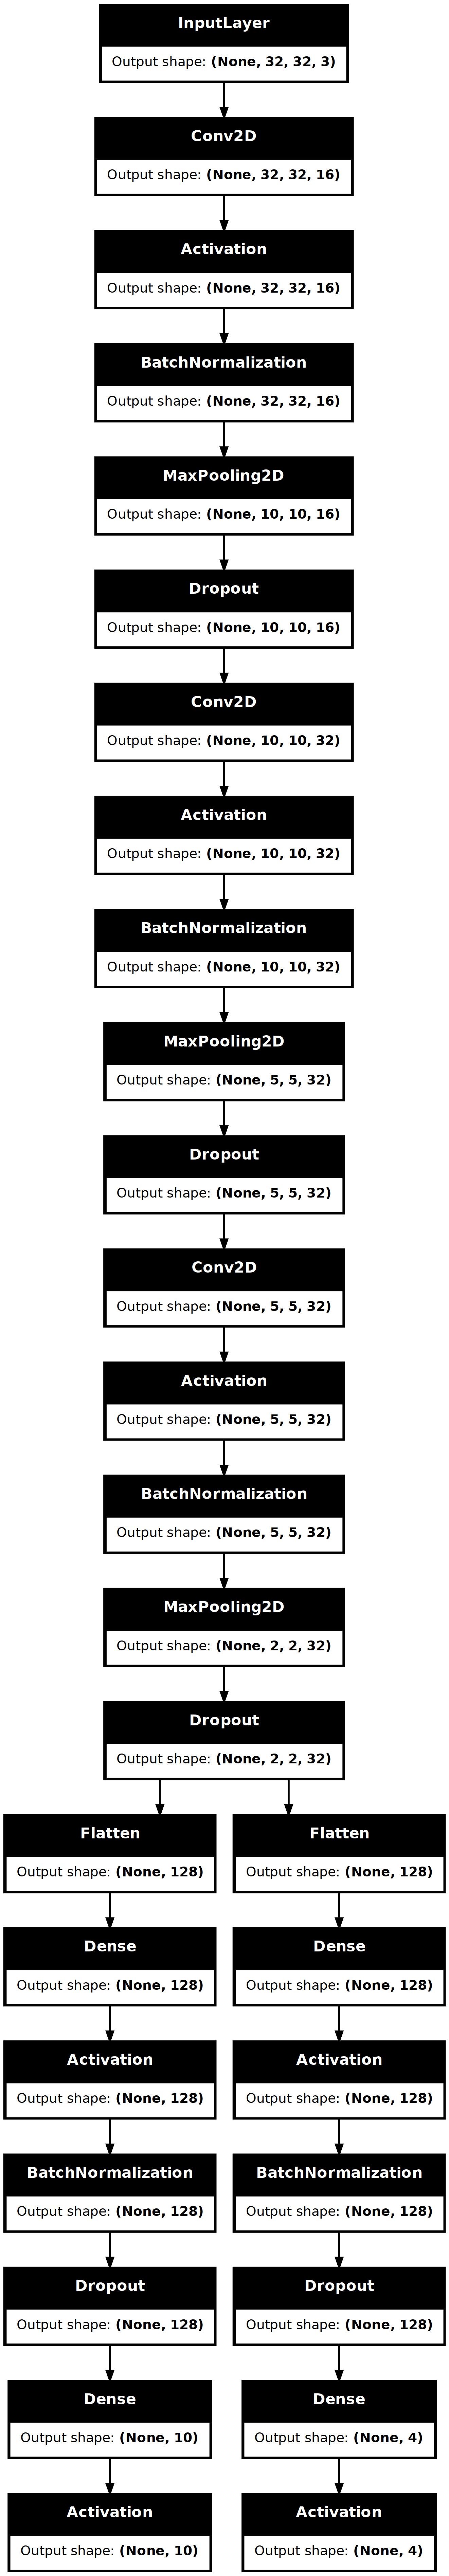

In [36]:
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(model, to_file='mtl_model.png', show_shapes=True)

In [38]:
model.compile(optimizer='adam', 
              loss={
                  'angle': 'categorical_crossentropy', 
                  'cifar10': 'categorical_crossentropy', 
                  },
              loss_weights={
                  'angle': 1., 
                  'cifar10': 4., 
                  },
              metrics={
                  'angle': 'accuracy',
                  'cifar10': 'accuracy'})

In [39]:
history = model.fit(
    x,
    [y_cifar10, y_angle],
    epochs=5,
    batch_size=32
)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - angle_accuracy: 0.3321 - cifar10_accuracy: 0.1205 - loss: 1.6562
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - angle_accuracy: 0.3922 - cifar10_accuracy: 0.1214 - loss: 1.3681
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - angle_accuracy: 0.4045 - cifar10_accuracy: 0.1206 - loss: 1.3445
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - angle_accuracy: 0.4240 - cifar10_accuracy: 0.1221 - loss: 1.3215
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - angle_accuracy: 0.4346 - cifar10_accuracy: 0.1274 - loss: 1.2890


In [43]:
history.history.keys()

dict_keys(['angle_accuracy', 'cifar10_accuracy', 'loss'])

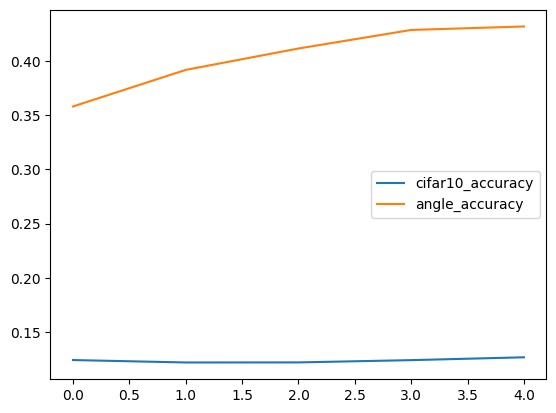

KeyError: 'angle_loss'

In [44]:
plt.plot(history.history['cifar10_accuracy'])
plt.plot(history.history['angle_accuracy'])
plt.legend(['cifar10_accuracy', 'angle_accuracy'])
plt.show()

plt.plot(history.history['angle_loss'])
plt.plot(history.history['cifar10_loss'])
plt.plot(history.history['loss'])
plt.legend(['angle_loss', 'cifar10_loss', 'loss'])
plt.show()

In [46]:
# model.save_weights('./mtn3.h5')
model.save_weights('./custom_mtl.weights.h5')
model.save('./custom_mtl_model.h5')
model.save('./custom_mtl_model.keras')